В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [118]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
import time
from colorama import Style
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import scikitplot as skplt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt
from category_encoders import LeaveOneOutEncoder

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [52]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [53]:
def sigmoid(h):
    return 1. / (1 + np.exp(-h))

def probability(theta, X):
    result = sigmoid(np.dot(X, theta))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [54]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = np.where(prob >= threshold, 1, 0)
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [55]:
def logloss(theta, X, y): 
    p = probability(theta, X)
    result = - np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    return result

In [56]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$
      

Реализуйте рассчет градиента в матричном виде:

In [57]:
def gradient(theta, X, y):
    y_pred = binary_class_prediction(theta, X)
    grad = 2 * (y_pred - y)[:, np.newaxis] * X
    grad = grad.mean(axis=0)
    return grad

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [58]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [59]:
X, y = make_classification(n_samples=2000, random_state=42)

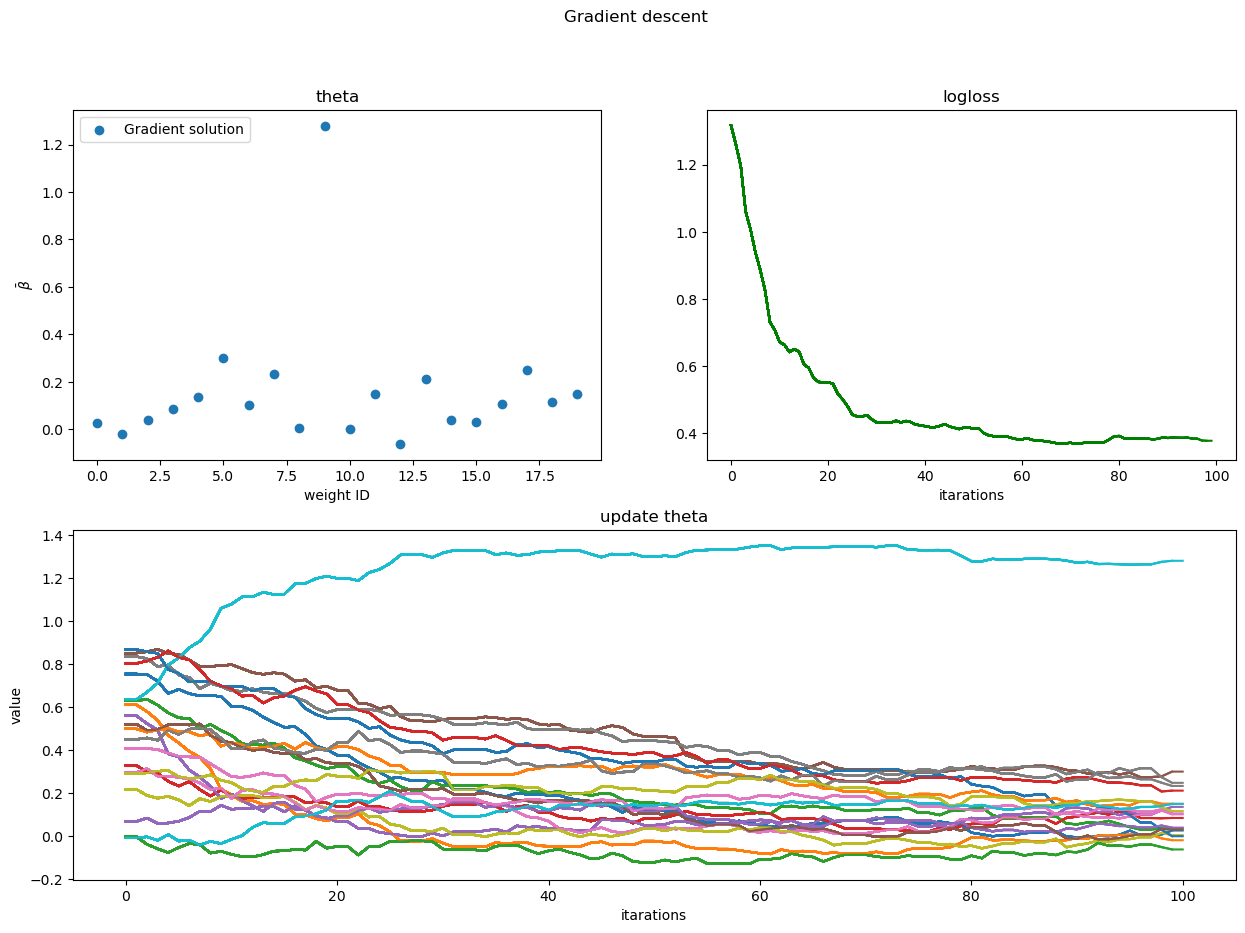

In [60]:
optimal_theta = fit(X, y)

In [14]:
y_pred = binary_class_prediction(optimal_theta, X)

## Основное задание

In [61]:
df = pd.read_csv('weather.csv')

In [63]:
df.sample(5)

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
113127,115930,2012-09-02,PearceRAAF,5.0,21.1,NaN,NaN,8.3,W,33.0,...,74.0,52.0,1018.5,1014.2,NaN,NaN,15.0,19.1,NaN,Yes
15958,16327,2012-06-04,Newcastle,13.2,20.3,14.4,NaN,NaN,NaN,NaN,...,97.0,72.0,NaN,NaN,6.0,6.0,14.5,17.6,Yes,No
136369,139559,2009-09-22,Darwin,27.2,33.3,0.0,7.8,7.6,WNW,44.0,...,68.0,54.0,1012.3,1008.2,7.0,3.0,29.3,32.4,No,No
119336,122267,2013-03-15,Perth,15.5,29.2,26.2,2.4,7.7,ESE,31.0,...,69.0,58.0,1010.7,1010.6,4.0,4.0,24.3,27.3,Yes,No
105682,108275,2016-09-03,Woomera,7.1,20.4,0.0,5.0,NaN,SW,46.0,...,72.0,39.0,1019.5,1018.8,6.0,5.0,11.7,18.4,No,No


In [64]:
df.shape

(142193, 24)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     142193 non-null  int64  
 1   Date           142193 non-null  object 
 2   Location       142193 non-null  object 
 3   MinTemp        141556 non-null  float64
 4   MaxTemp        141871 non-null  float64
 5   Rainfall       140787 non-null  float64
 6   Evaporation    81350 non-null   float64
 7   Sunshine       74377 non-null   float64
 8   WindGustDir    132863 non-null  object 
 9   WindGustSpeed  132923 non-null  float64
 10  WindDir9am     132180 non-null  object 
 11  WindDir3pm     138415 non-null  object 
 12  WindSpeed9am   140845 non-null  float64
 13  WindSpeed3pm   139563 non-null  float64
 14  Humidity9am    140419 non-null  float64
 15  Humidity3pm    138583 non-null  float64
 16  Pressure9am    128179 non-null  float64
 17  Pressure3pm    128212 non-nul

In [5]:
df.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,142193.000000,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,72884.900649,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,42069.147355,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,0.000000,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,36235.000000,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,73311.000000,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,109247.000000,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,145458.000000,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


Заменим в столбцах RainTomorrow и RainToday значения Yes на `1`, а значения No на `0`

In [68]:
df.RainTomorrow = df.RainTomorrow.replace({'No':0, 'Yes': 1})
df.RainToday = df.RainToday.replace({'No':0, 'Yes':1})

Так как погода имеет циклический характер, дата измерения может нести полезную информацию для модели. Чтобы модель могла работать с датой уберем столбец Date и добавим два новых столбца Month и Day - месяц и день измерения. Год измерения мы учитывать не будем, ведь погода слабо зависит от года, при этом месяц и день сильно влияют. Например, очевидно, что нет особой разницы в измерениях сделанных в один и тот же день, но в разный год.

In [69]:
df["Date"] = pd.to_datetime(df["Date"])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop("Date", axis=1, inplace=True)

In [70]:
df.head()

,Unnamed: 0,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Day
0,0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0,12,1
1,1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0,12,2
2,2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0,12,3
3,3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0,12,4
4,4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0,12,5


Первое, что стоит заметить &mdash; у нас в данных есть уникальное для каждого объекта поле Unnamed: 0(аналог поля id). Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

In [71]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [72]:
df.shape

(142193, 24)

Разделим данные на обучающую и тестовую выборки, размер обучающий выборки - 75%, оставшиеся 25% оставим для тестирования модели.

In [75]:
y = df["RainTomorrow"]
X = df.drop(columns=["RainTomorrow"])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False)

Посмотрим на значения целевой переменной

<Axes: xlabel='RainTomorrow', ylabel='Density'>

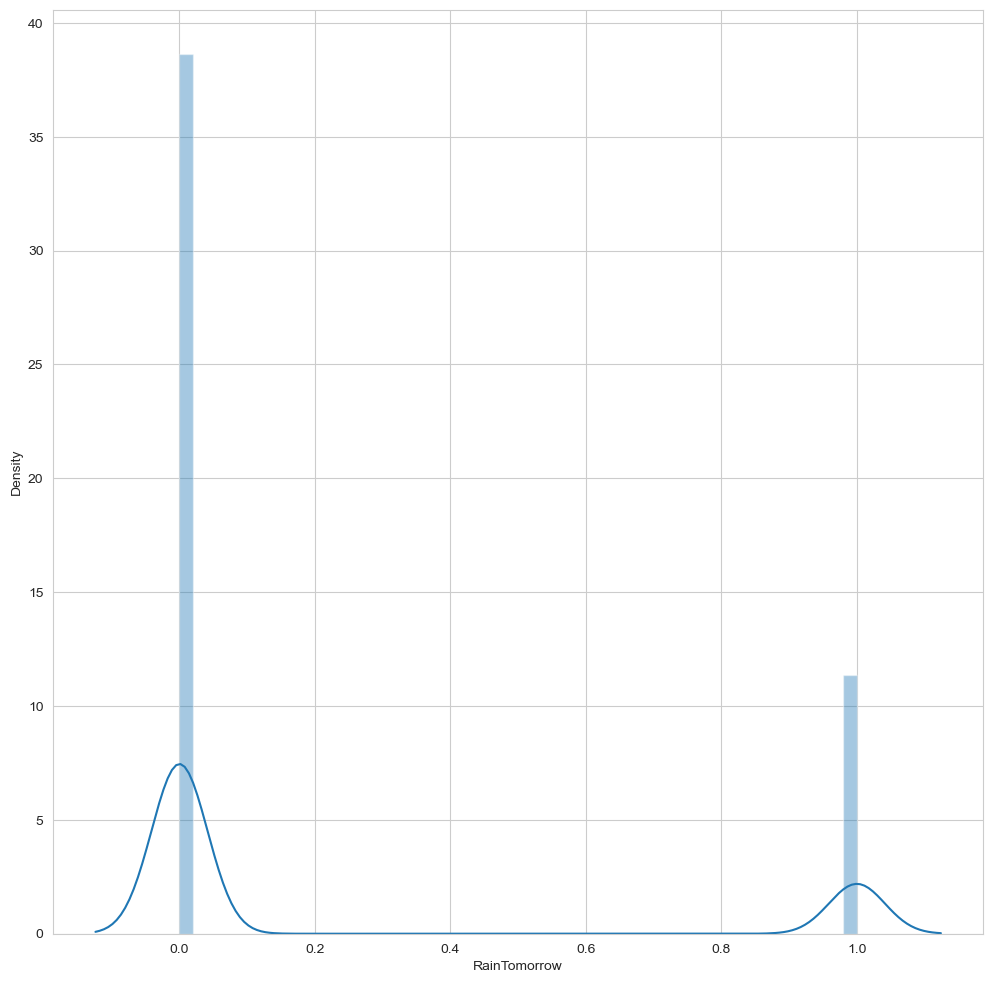

In [77]:
sns.distplot(y_train)

По гистограмме видно, что у нас в датасете объектов со значением целевой переменной 0 намного больше, чем объектов со значением целевой переменной 1. То есть в датасете присутствует дизбаланс классов, что не есть хорошо. В будущем постораемся учесть дизбаланс с помощью задания весов для классовю.

Посмотрим на количество пропусков в данных

In [78]:
df.isnull().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
Month                0
Day                  0
dtype: int64

Посмотрим на корреляцию признаков и заполним пропуски в численных признаках средним значением.

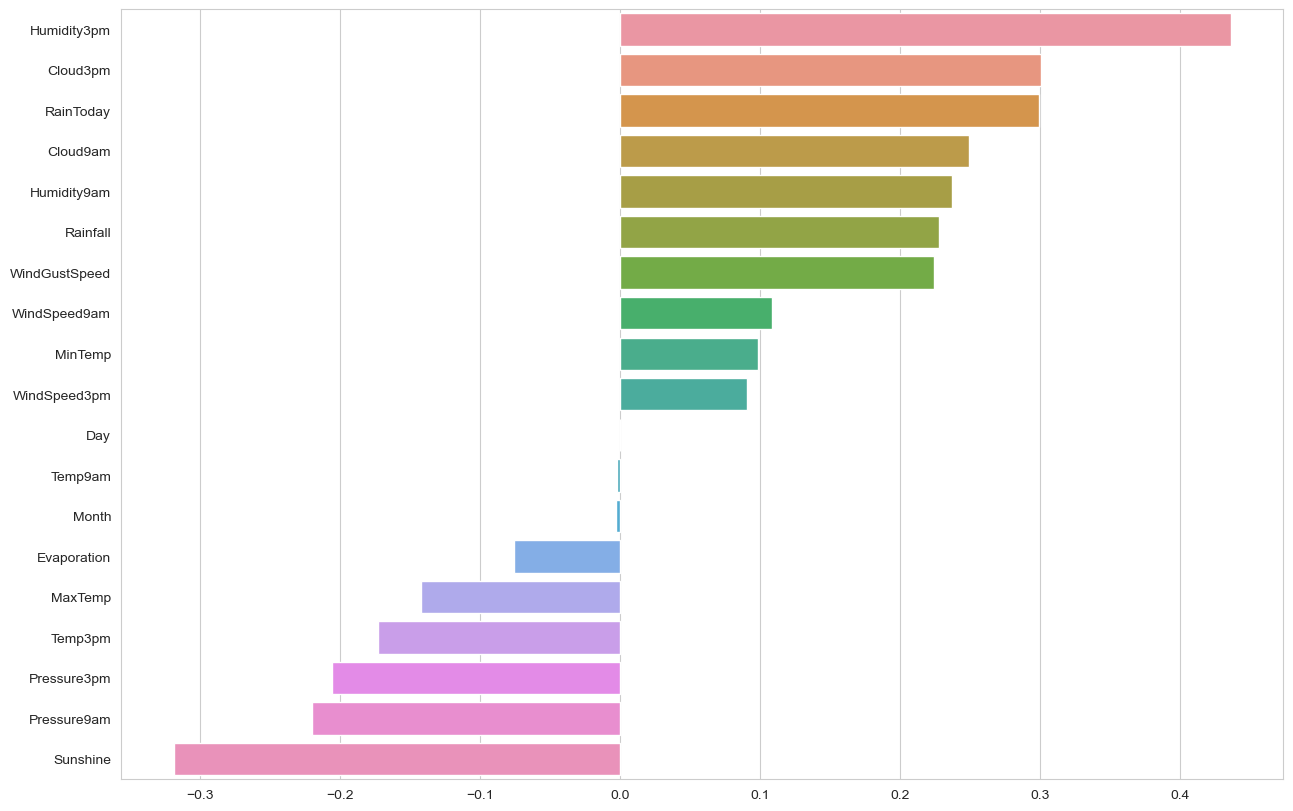

In [79]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

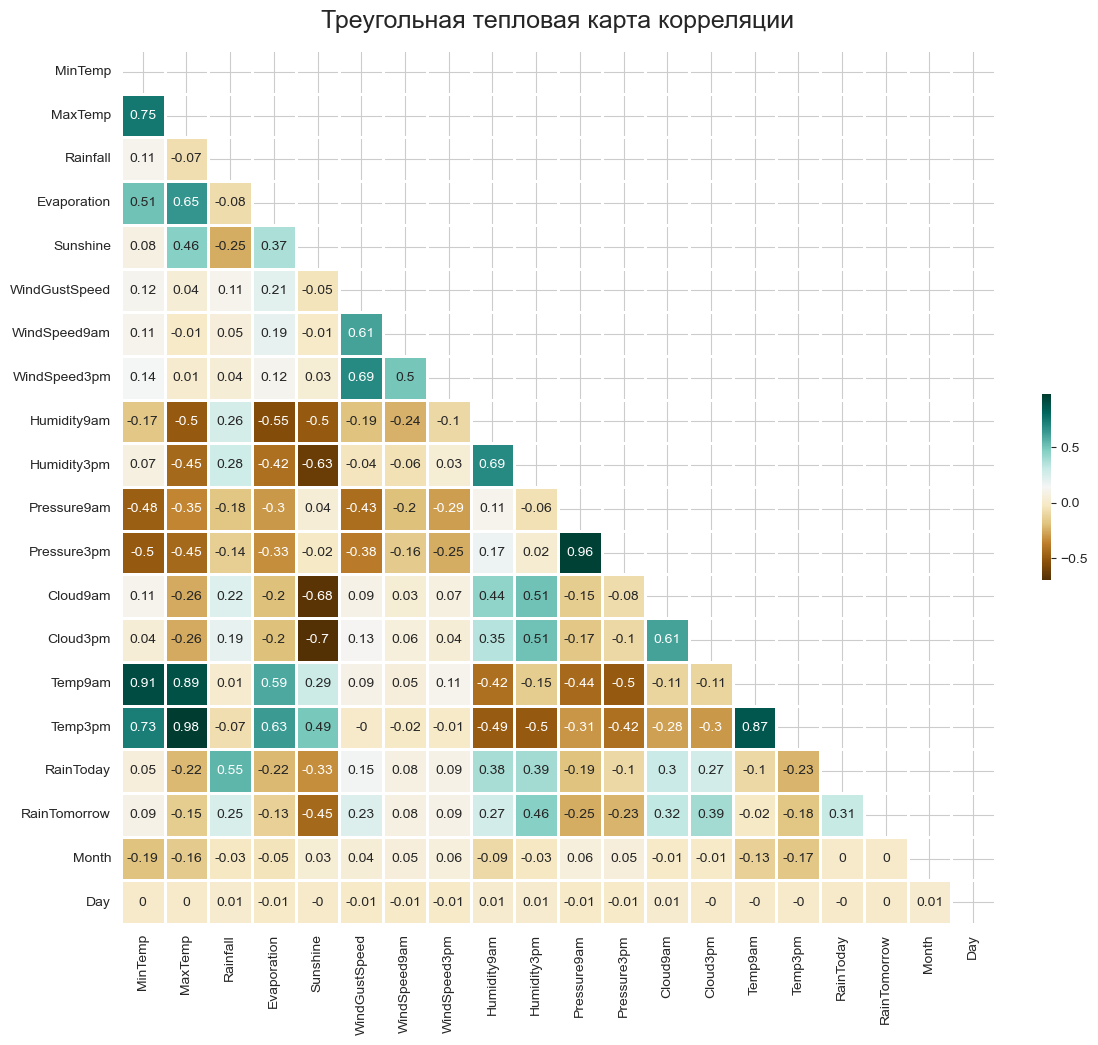

In [80]:
plt.rcParams["figure.figsize"] = (12, 12)

sns.set_style("whitegrid")

mask = np.triu(np.ones_like(df.dropna().corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
    df.dropna().corr(numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.01},
    linewidth=1,
    
    mask=mask,
)

heatmap.set_title(
    "Треугольная тепловая карта корреляции", fontdict={"fontsize": 18}, pad=16
);

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет.

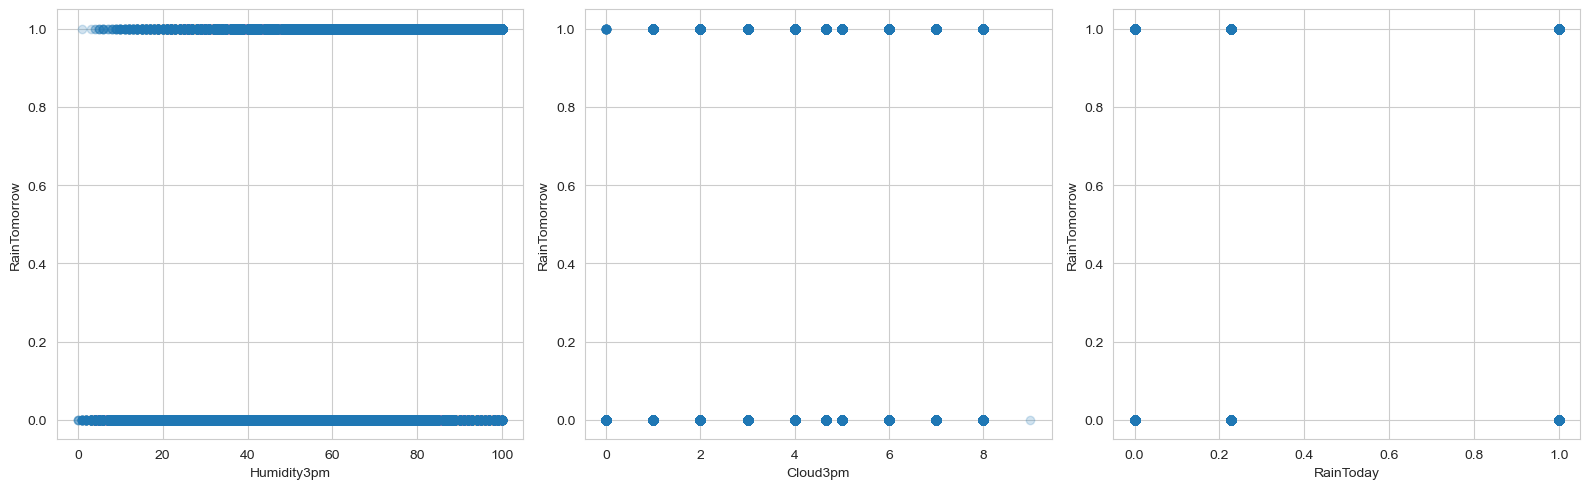

In [81]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["Humidity3pm", "Cloud3pm", "RainToday"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("RainTomorrow")
plt.tight_layout()

In [89]:
# Категориальные признаки
cat_features = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm"]

Обучем первую модель на числовых признаках.

In [94]:
model = LogisticRegression()

model.fit(X_train[numeric_features], y_train)

y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print(Style.BRIGHT + "Test classification report")
print(Style.NORMAL + classification_report(y_test, y_pred))
print(Style.BRIGHT + "Train classification report")
print(Style.NORMAL + classification_report(y_train_pred, y_train))

Test classification report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     27882
           1       0.77      0.40      0.53      7667

    accuracy                           0.85     35549
   macro avg       0.81      0.68      0.72     35549
weighted avg       0.84      0.85      0.83     35549

Train classification report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     90679
           1       0.47      0.71      0.57     15965

    accuracy                           0.84    106644
   macro avg       0.71      0.78      0.73    106644
weighted avg       0.87      0.84      0.85    106644



Посмотрим на качество модели при помощи кросс-валидации

В качестве метрики будем использовать roc-auc score

In [97]:
cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="roc_auc")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV roc_auc_score = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.8938
	0.8200
	0.8358
	0.8463
	0.8211
	0.8372
	0.8681
	0.8392
	0.8800
	0.8638
Mean CV roc_auc_score = 0.8505


Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам.

In [101]:
model.coef_

array([[ 0.00930593,  0.01017669,  0.02492443, -0.01395802, -0.12092679,
         0.06398904, -0.0127572 , -0.02903143,  0.00544505,  0.05541799,
         0.03661265, -0.04414947,  0.04878329,  0.09331883,  0.00334282,
         0.01893262,  0.01479535,  0.02201284, -0.00099447]])

In [102]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

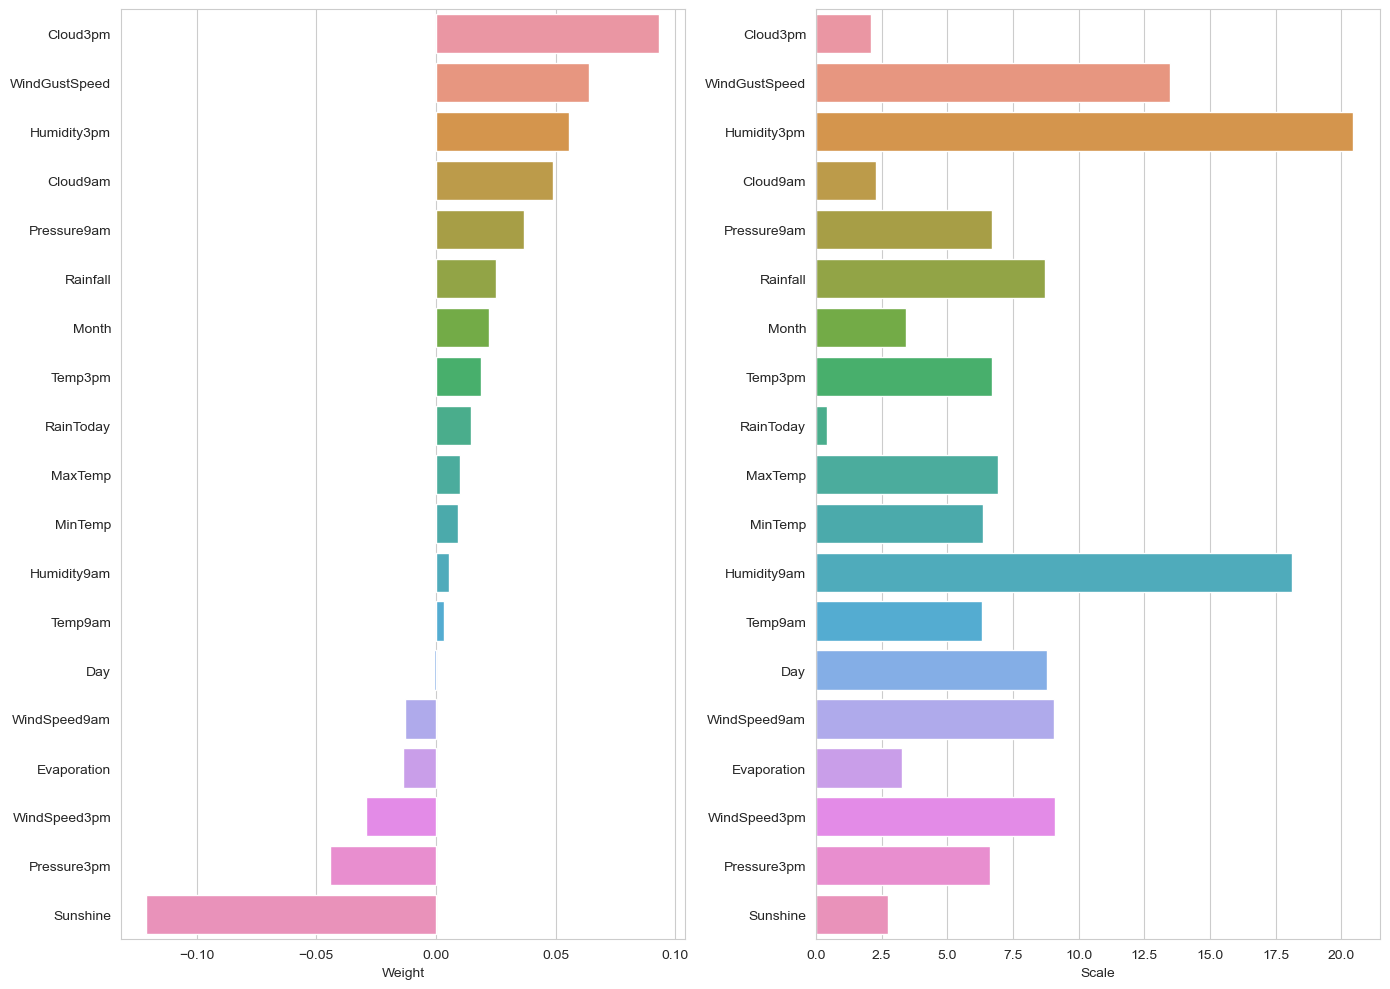

In [104]:
show_weights(numeric_features, model.coef_.reshape(19,), X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени. 

Для этого воспользуемся трансформером StandardScaler.

In [105]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print(Style.BRIGHT + "Test classification report")
print(Style.NORMAL + classification_report(y_test, y_pred))
print(Style.BRIGHT + "Train classification report")
print(Style.NORMAL + classification_report(y_train_pred, y_train))

Test classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     27882
           1       0.77      0.44      0.56      7667

    accuracy                           0.85     35549
   macro avg       0.81      0.70      0.74     35549
weighted avg       0.84      0.85      0.83     35549

Train classification report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     90162
           1       0.49      0.71      0.58     16482

    accuracy                           0.84    106644
   macro avg       0.71      0.79      0.74    106644
weighted avg       0.87      0.84      0.85    106644



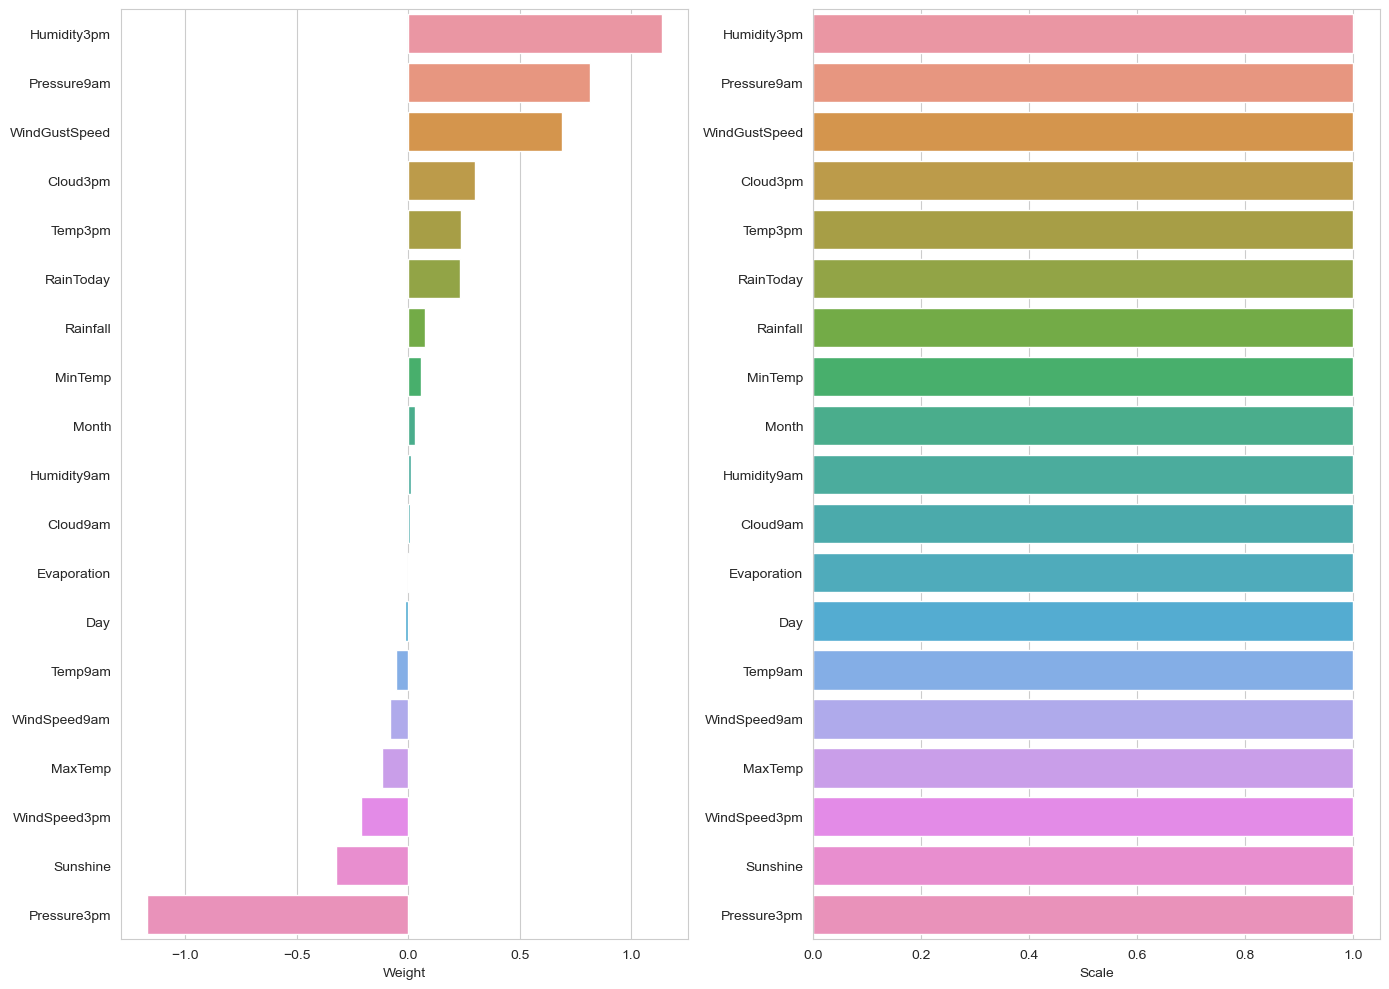

In [106]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_.reshape(19,), scales)

Оптимизируем гиперпараметры нашей модели. В данном случае `C` - наказание за "переобучение".

Best C = 1.5000


Text(0, 0.5, 'CV score')

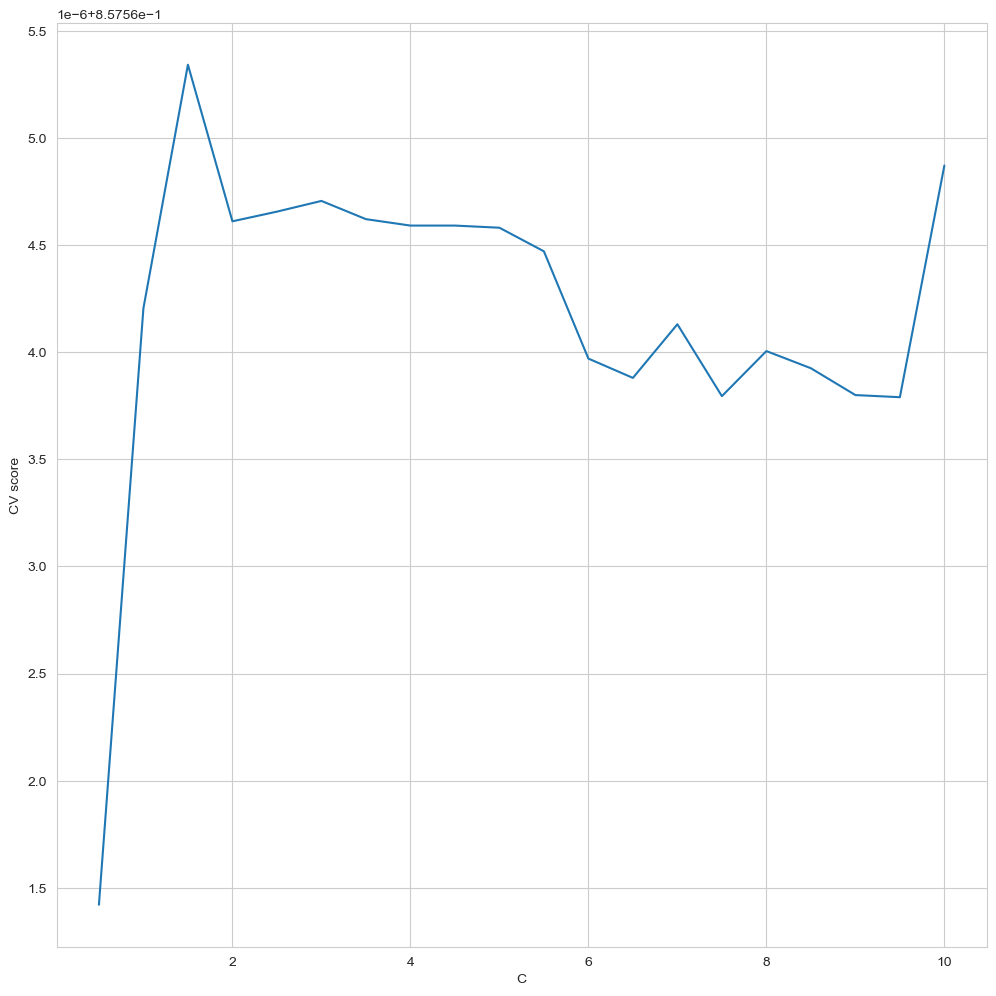

In [108]:
C = np.linspace(-10, 10, 41)
searcher = GridSearchCV(LogisticRegression(), [{"C": C}], scoring="roc_auc", cv=10)
searcher.fit(X_train_scaled, y_train)

best_c = searcher.best_params_["C"]
print("Best C = %.4f" % best_c)

plt.plot(C, searcher.cv_results_["mean_test_score"])
plt.xlabel("C")
plt.ylabel("CV score")

Построем `Pipeline` с полученным оптимальным значением гиперпараметром + добавим веса классов, чтобы учесть дизбаланс.

In [109]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

print(class_weights)

[0.6444804  2.23033849]


In [113]:
simple_pipeline = Pipeline([
    ("scaling", StandardScaler()),
    ("model", LogisticRegression(C=best_c, class_weight=dict(enumerate(class_weights))))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test roc_auc = %.4f" % roc_auc_score(y_test, y_pred))

Test roc_auc = 0.7933


## Работа с категориальными признаками

In [114]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [115]:
X_train[categorical].sample(5)

,Location,WindGustDir,WindDir9am,WindDir3pm
63023,MelbourneAirport,SW,N,SW
65652,MelbourneAirport,N,N,NE
97861,MountGambier,W,NNW,WNW
41950,Wollongong,W,WNW,SW
14194,Moree,W,SSW,SW


In [119]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('model', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test roc_auc = %.4f" % roc_auc_score(y_test, y_pred))

Test roc_auc = 0.7108


In [120]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (106644, 23)
Size after OneHot: (106644, 107)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить логистическую регрессию с $\ell_1$-регуляризатором. 

In [122]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('model', LogisticRegression(penalty='l1', solver='liblinear'))
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("roc_auc = %.4f" % roc_auc_score(y_test, y_pred))

roc_auc = 0.7209


In [123]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 6


In [124]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('model', LogisticRegression(C=best_c, class_weight=dict(enumerate(class_weights))))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"roc_auc_score: {roc_auc_score(y_test, y_pred)}")

roc_auc_score: 0.790000604571351


In [142]:
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="roc_auc")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV roc_auc_score = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.8099
	0.7955
	0.7737
	0.8457
	0.6815
	0.7531
	0.8078
	0.8286
	0.6254
	0.8756
Mean CV roc_auc_score = 0.7797


## Работа с пропусками

In [125]:
df.isna().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
Month                0
Day                  0
dtype: int64

Посмотрев количество пропусков, понятно, что просто удалив все пропуски мы потеряем большое количество, поэтому попробуем заполнить пропущенные значения.

Посмотрим распределения признаков и проверим их на наличие выбросов.

array([[<Axes: title={'center': 'MinTemp'}>,
        <Axes: title={'center': 'MaxTemp'}>,
        <Axes: title={'center': 'Rainfall'}>,
        <Axes: title={'center': 'Evaporation'}>,
        <Axes: title={'center': 'Sunshine'}>],
       [<Axes: title={'center': 'WindGustSpeed'}>,
        <Axes: title={'center': 'WindSpeed9am'}>,
        <Axes: title={'center': 'WindSpeed3pm'}>,
        <Axes: title={'center': 'Humidity9am'}>,
        <Axes: title={'center': 'Humidity3pm'}>],
       [<Axes: title={'center': 'Pressure9am'}>,
        <Axes: title={'center': 'Pressure3pm'}>,
        <Axes: title={'center': 'Cloud9am'}>,
        <Axes: title={'center': 'Cloud3pm'}>,
        <Axes: title={'center': 'Temp9am'}>],
       [<Axes: title={'center': 'Temp3pm'}>,
        <Axes: title={'center': 'RainToday'}>,
        <Axes: title={'center': 'RainTomorrow'}>,
        <Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Day'}>]], dtype=object)

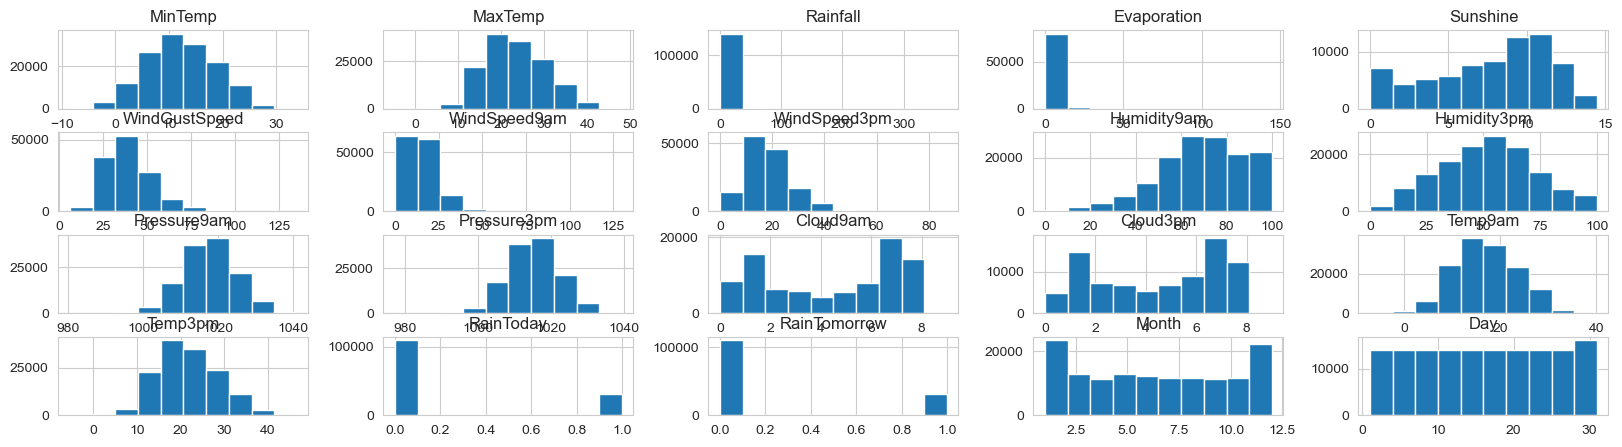

In [126]:
df.hist(figsize=(20, 5), layout=(-1, 5))

<Axes: >

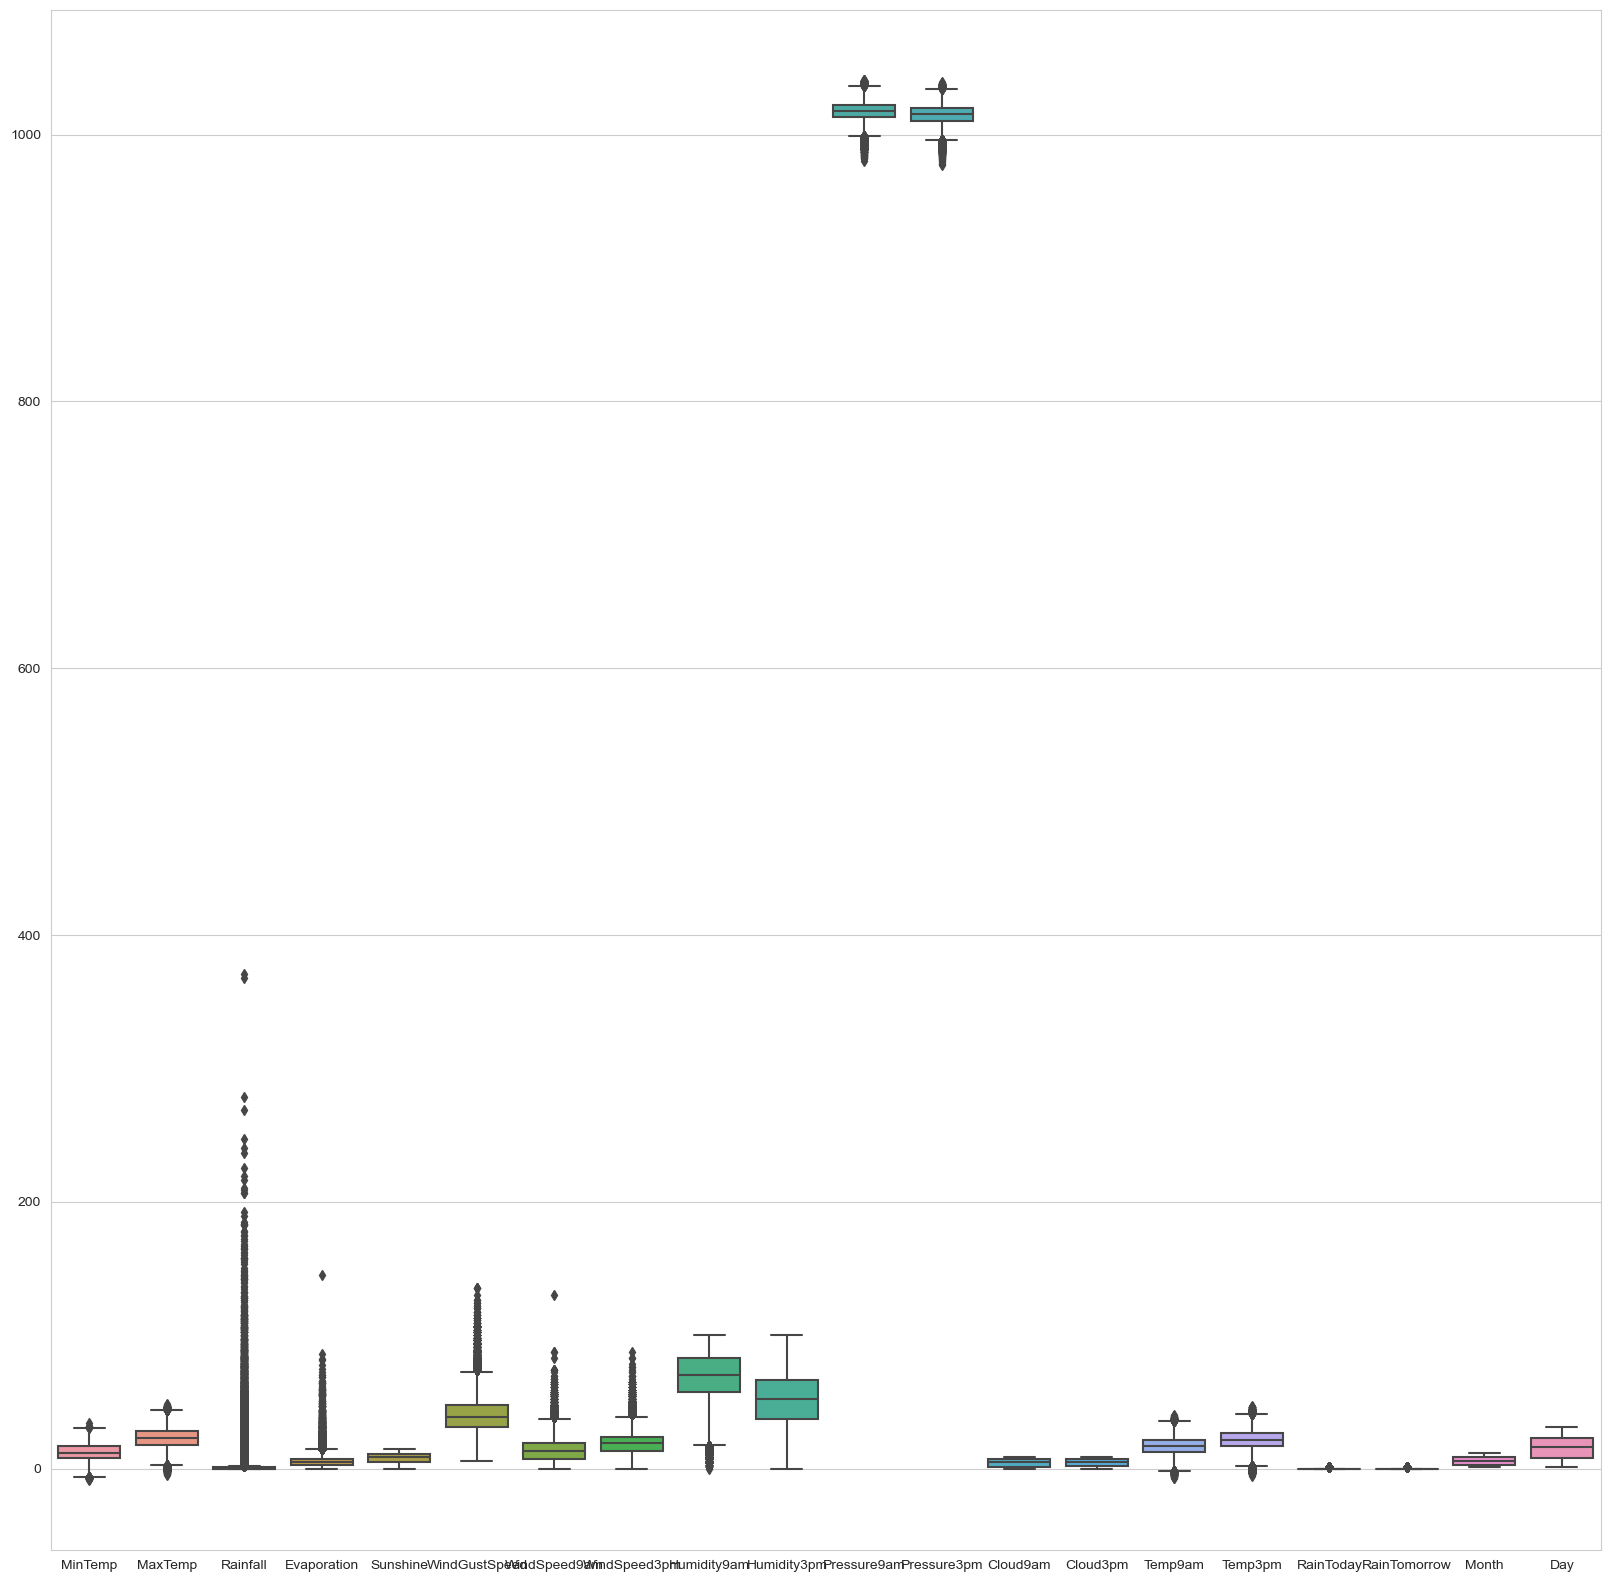

In [127]:
plt.rcParams["figure.figsize"] = (20, 20)

sns.boxplot(data=df)

Как видно у нас есть признаки, которые по треугольной тепловой карте имееют высокую корреляцию с другими признаками и целевой переменной, но при этом имею большое количество пропусков, что не дает нам возможности просто выкинуть пропуски.

При этом есть признаки, у которых большое количество выбросов, следовательно, заполнить пропуски средним/медианой вряд ли даст хороший результат, т.к. они чувствительны к выбросам.

Для заполнения пропусков в таких признаках попробуем использовать интерполяцию.

In [128]:
df.isna().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
Month                0
Day                  0
dtype: int64

Есть признаки с малым количеством пропусков, например: MinTemp, MaxTemp Temp3pm, Temp9am. Для них просто выбросим пропуски.

Также есть признак RainToday, у которого тоже мало пропусков, но этот признак несет очень важную информацию и является одним из ключевых для предсказания, так что не будем выбрасыввать пропуски для этого признака, постараемся их заполнить

In [166]:
drop_na_columns = ["MinTemp", "MaxTemp", "Temp9am", "Temp3pm", 
                   "Humidity9am", "Humidity3pm", "WindSpeed9am", 
                   "WindSpeed3pm", "WindDir3pm", "WindGustDir", "WindDir9am", "RainToday"]
fill_with_mean_columns = ["Cloud3pm", "Cloud9am", "Pressure3pm", 
                   "Pressure9am", "Rainfall", "Evaporation", "Sunshine", 
                   "WindGustSpeed"]
fill_with_interpolation_columns = ["Evaporation", "Sunshine", "WindGustSpeed"]

Удаляем пропуски

In [167]:
df.dropna(subset=drop_na_columns, inplace=True)

In [131]:
df.shape

(122693, 24)

In [132]:
df.isna().sum()

Location             0
MinTemp              0
MaxTemp              0
Rainfall           903
Evaporation      50604
Sunshine         55633
WindGustDir          0
WindGustSpeed        0
WindDir9am           0
WindDir3pm           0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am       8862
Pressure3pm       8812
Cloud9am         45986
Cloud3pm         47313
Temp9am              0
Temp3pm              0
RainToday          903
RainTomorrow         0
Month                0
Day                  0
dtype: int64

Заполняем пропуски интерполяцией

In [155]:
for column in fill_with_interpolation_columns:
    df[column].interpolate(inplace=True)

In [156]:
df.isnull().sum()

Location             0
MinTemp              0
MaxTemp              0
Rainfall           903
Evaporation       4910
Sunshine          4910
WindGustDir          0
WindGustSpeed        0
WindDir9am           0
WindDir3pm           0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am       8862
Pressure3pm       8812
Cloud9am         45986
Cloud3pm         47313
Temp9am              0
Temp3pm              0
RainToday          903
RainTomorrow         0
Month                0
Day                  0
dtype: int64

Заполняем средним.

In [157]:
for column in fill_with_mean_columns:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [168]:
df.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Month            0
Day              0
dtype: int64

Попробуем использовать LabelEncoder

In [169]:
le = LabelEncoder()

In [170]:
for column in cat_features:
    df[column] = le.fit_transform(df[column])

In [259]:
X = df.drop(['RainTomorrow'],axis=1)
y = df['RainTomorrow']

In [260]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, shuffle=False)

In [174]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [175]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [176]:
scaler.fit(X_train_scaled)


X_train_scaled = scaler.transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

In [177]:
lr = LogisticRegression()

In [178]:
lr.fit(X_train_scaled, y_train)

LogisticRegression()

In [179]:
y_pred = lr.predict(X_test_scaled)

In [180]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     24215
           1       0.76      0.47      0.58      6233

    accuracy                           0.86     30448
   macro avg       0.82      0.72      0.75     30448
weighted avg       0.85      0.86      0.85     30448



In [181]:
roc_auc_score(y_test, y_pred)

0.716808452834369

In [182]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

In [183]:
class_weights

array([0.64163488, 2.26510192])

In [184]:
new_model = LogisticRegression(class_weight=dict(enumerate(class_weights)))

In [185]:
new_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 0.6416348808294523, 1: 2.2651019193572384})

In [186]:
y_pred = new_model.predict(X_test_scaled)

In [187]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     24215
           1       0.57      0.76      0.65      6233

    accuracy                           0.83     30448
   macro avg       0.75      0.80      0.77     30448
weighted avg       0.86      0.83      0.84     30448



In [188]:
roc_auc_score(y_test, y_pred)

0.8042385882207492

In [189]:
cv_scores = cross_val_score(new_model, X_train_scaled, y_train, cv=10, scoring="roc_auc")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV roc_auc_score = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.8928
	0.8418
	0.8454
	0.8502
	0.8423
	0.8629
	0.8923
	0.8679
	0.8751
	0.8976
Mean CV roc_auc_score = 0.8668


### Выводы по Логистической регрессии

Модель на числовых признаках показала скор `0.7933`, со средним значением при кросс волидации - `0.85`. После преобразования категориальных признаков с помощью OneHotEncoder roc_auc score - `0.79` и средняя кросс волидация - `0.77`, но при этом после работы с категориальными признаками при кросс волидации получались модели с лучшим скором. Также стоит отметить важность учета дизбаланса классов. Так как в нашем датасете нулевой класс - доминирующий стоит это учитывать. Сделать это можно с помощью весов класса, то есть весов для штрафов модели за неправильное предсказание на конкретном классе. В нашем случае за ошибку на классе 1, модель будут сильнее штрафовать. После попытки поработать с пропусками и с учетом дизбаланса классов получаем модель с roc_auc - `0.8` и средней кросс волидацией - `0.8668`

## Метод ближайших соседей

Обучим модель на данных, полученных раньше.

In [192]:
knn_model = KNeighborsClassifier()

knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

In [193]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     24215
           1       0.65      0.44      0.52      6233

    accuracy                           0.84     30448
   macro avg       0.76      0.69      0.71     30448
weighted avg       0.82      0.84      0.82     30448



In [194]:
cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=10, scoring="roc_auc")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV roc_auc_score = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.7933
	0.7693
	0.7837
	0.7955
	0.7704
	0.8061
	0.8336
	0.8085
	0.7664
	0.8303
Mean CV roc_auc_score = 0.7957


### Подберем гиперпараметры

In [207]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # количество соседей
    'weights': ['uniform', 'distance'],  # веса соседей
    'p': [1, 2]  # параметр метрики (1 - Манхэттенское расстояние, 2 - Евклидово расстояние)
}

In [211]:
knn_grid = GridSearchCV(knn_model, param_grid, cv=5, scoring="roc_auc")

In [212]:
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [213]:
print("Лучшие гиперпараметры:", knn_grid.best_params_)
print("Лучшая оценка точности:", knn_grid.best_score_)

Лучшие гиперпараметры: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Лучшая оценка точности: 0.8341359113415965


In [214]:
best_knn = knn_grid.best_estimator_ 

best_knn.fit(X_train_scaled, y_train) 

y_pred = best_knn.predict(X_test_scaled)

In [216]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91     24215
           1       0.69      0.41      0.52      6233

    accuracy                           0.84     30448
   macro avg       0.78      0.68      0.71     30448
weighted avg       0.83      0.84      0.83     30448



In [217]:
cv_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=10, scoring="roc_auc")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV roc_auc_score = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.8432
	0.7930
	0.8360
	0.8508
	0.7976
	0.8481
	0.8803
	0.8466
	0.8037
	0.8672
Mean CV roc_auc_score = 0.8367


При подборе гиперпараметров результат улучшается, но логистичская реграссия показывает себя лучше.

## Байесовский классификатор

In [224]:
nb_model = GaussianNB()

nb_model.fit(X_train_scaled, y_train)

y_pred = nb_model.predict(X_test_scaled)

In [225]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     24215
           1       0.63      0.56      0.60      6233

    accuracy                           0.84     30448
   macro avg       0.76      0.74      0.75     30448
weighted avg       0.84      0.84      0.84     30448



In [226]:
cv_scores = cross_val_score(nb_model, X_train_scaled, y_train, cv=10, scoring="roc_auc")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV roc_auc_score = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.8512
	0.8210
	0.8219
	0.7603
	0.7962
	0.8133
	0.8486
	0.8179
	0.8508
	0.8542
Mean CV roc_auc_score = 0.8235


## Подбор гиперпараметров

In [227]:
param_grid = {
    'priors': [None, [0.2, 0.8], [0.5, 0.5]],  # Разные варианты априорных вероятностей
    'var_smoothing': [1e-9, 1e-8, 1e-7]  # Разные значения сглаживания дисперсии
}

In [229]:
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring="roc_auc", cv=5)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'priors': [None, [0.2, 0.8], [0.5, 0.5]],
                         'var_smoothing': [1e-09, 1e-08, 1e-07]},
             scoring='roc_auc')

In [231]:
print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучшая оценка точности:", grid_search.best_score_)

Лучшие гиперпараметры: {'priors': [0.5, 0.5], 'var_smoothing': 1e-07}
Лучшая оценка точности: 0.821456651248927


In [232]:
best_nb = grid_search.best_estimator_ 

best_nb.fit(X_train_scaled, y_train) 

y_pred = best_nb.predict(X_test_scaled)

In [233]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     24215
           1       0.57      0.66      0.61      6233

    accuracy                           0.83     30448
   macro avg       0.74      0.77      0.75     30448
weighted avg       0.84      0.83      0.83     30448



In [234]:
cv_scores = cross_val_score(best_nb, X_train_scaled, y_train, cv=10, scoring="roc_auc")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV roc_auc_score = %.4f" % np.mean(cv_scores))

Cross validation scores:
	 0.8512
	0.8210
	0.8219
	0.7603
	0.7962
	0.8133
	0.8486
	0.8179
	0.8508
	0.8542
Mean CV roc_auc_score = 0.8235


Байесовский классификатор показывает результаты схожие с knn, но хуже чем логистическая регрессия. При этом стоит учитывать что байесовский классификатор не так сильно переобучается под тренеровучную выборку, как KNN. Что тоже важно и это стоит учитывать.

## Логистическая регрессия реализованная самостоятельно

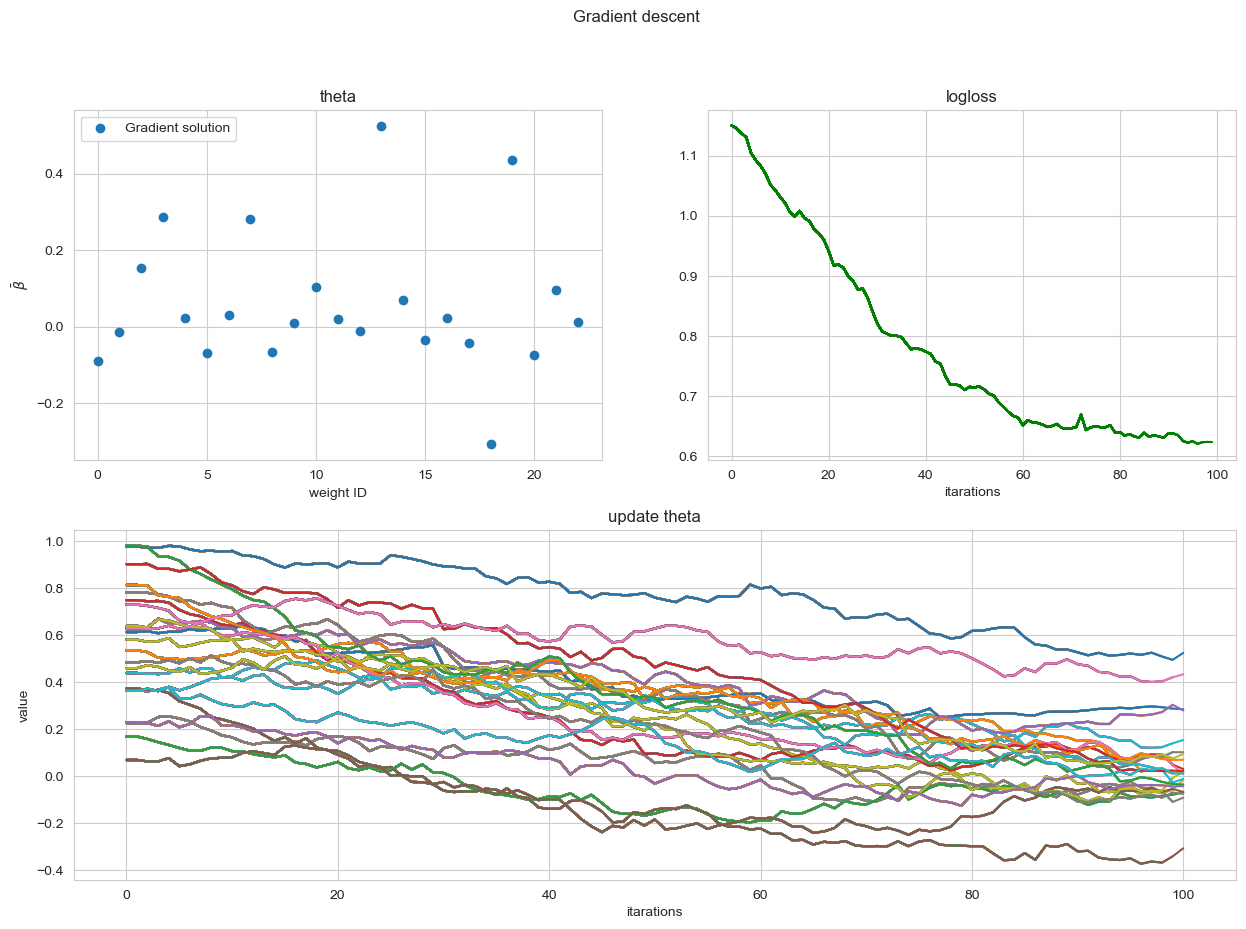

In [261]:
my_theta = fit(X_train_scaled, y_train.values)

In [262]:
my_lr_y_train_pred = binary_class_prediction(my_theta, X_train_scaled)
my_lr_y_pred = binary_class_prediction(my_theta, X_test_scaled)

In [263]:
my_lr_standard_train_score = roc_auc_score(y_train, my_lr_y_train_pred)
my_lr_standard_test_score = roc_auc_score(y_test, my_lr_y_pred)

In [266]:
print(f'Train roc_auc_score: {np.round(my_lr_standard_train_score, 3)}')
print(f'Test roc_auc_score: {np.round(my_lr_standard_test_score, 3)}')

Train roc_auc_score: 0.721
Test roc_auc_score: 0.716


### Вывод по моей реализации логистической регрессии

Моя реализация логистической регрессии показывает неплохие результаты, но все же хуже, чем реализация из библиотеке `sklearn`

# Вывод

 1. Лучшие результаты показывает логистическая регрессия из библиотеке sklearn
 2. Метод ближайших соседей показывает результаты хуже чем логистическая регресия, при этом сильно переобучается под тренеровочную выборку(что логично). И работает дольше остальных моделей, т.к. по факту KNN - просто запоминает тренеровочную выборку
 3. Байесовский классификатор работает намного быстрее чем KNN, при этом показывая похожие результаты на отложенной выборке. Но все равно хуже чем логистическая регрессия.
 4. Моя реализация логистической регрессии работает не так долго как KNN, но чуть дольше остальных моделей. Показывая результат хуже чем все вышеперечисленные модели.